## Tensorflow noteboook for showcasing tensorboard profiler inside a jupyter notebook instance

This notebook contains the code and explanations concerning the training of simple tensorflow model using `Fashion MNIST data`. 

- The objectives of this notebook are :
    - Install the Profiler, and access the various tools available via tensorboard
    - Demonstrate how to use the tools available with the TensorFlow Profiler to track model performance 
    - Understand the hardware resource consumption
    - Actionable steps based on recommendations from the profiler



# 1 - Setup 

### Importing Libraries

In [2]:
from datetime import datetime
from packaging import version
import os
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')
tfds.disable_progress_bar()
import tensorflow as tf
print("TensorFlow version: ", tf.__version__) #checking `tensorflow` version

2022-02-18 17:24:25.727080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 17:24:25.727123: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version:  2.7.1


# 2 - Preparing the dataset

- For the sake of simplicity, we will be using one of the pre existing dataset inside tensorflow datasets.
- Here in this demo we are using fashion MNIST dataset

### Loading the fashion MNIST dataset from `tensorflow_datasets` 

- shuffle_files : whether to shuffle the input files
- as_supervised : if True, the returned tf.data.Dataset will have a 2-tuple structure ` eg:(input, label)

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-02-18 17:24:33.793739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-18 17:24:33.793797: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-18 17:24:33.793821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (test-vm-3): /proc/driver/nvidia/version does not exist
2022-02-18 17:24:33.794128: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset fashion_mnist downloaded and prepared to /home/jupyter/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# 3 - Preprocessing of the train and test data
- normalizing the values
    - We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

    - We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.
- chaning the datatype

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

#train
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.batch(128)

#test
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(128)

# 4 - Creating a simple image classification model using Keras.

1) `Activation_functions`: Activation function decides, whether a neuron should be activated or not.
- `relu function`:The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero
     - With default values, this returns the standard ReLU activation: max(x, 0), the element-wise maximum of 0 and the input tensor.
      - The rectified linear activation function overcomes the `vanishing gradient` problem, allowing models to learn faster and perform better.
- `Softmax` The softmax function is used as the activation function in the `output layer` of neural network models that predict a `multinomial` probability distribution. That is, softmax is used as the activation function for `multi-class classification` problems where class membership is required on more than two class labels.

2) Training a neural network involves passing data forward, through the model, and comparing predictions with `ground truth` labels. This comparison is done by a loss function. In multiclass classification problems, `categorical crossentropy` loss is the loss function of choice. However, it requires that your labels are `one-hot encoded`, which is not always the case.
- In such case, `sparse categorical crossentropy` loss can be a good choice. This loss function performs the same type of loss – categorical crossentropy loss – but works on integer targets instead of one-hot encoded ones. Saves you that to_categorical step which is common with TensorFlow/Keras models!

3) `Optimizer` —This is how the model is updated based on the data it sees and its loss function.
    - Optimizers are Classes or methods used to change the attributes of your machine/deep learning model such as weights and learning rate in order to reduce the losses
    - `Adam` is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
    
4) `learning rate`: The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.
- Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs
- In this notebook we have given `0.001` as the learning rate for adam optimizer

5) `Metrics` —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.
    - A metric is a function that is used to judge the performance of your model. Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model
    - In this notebook we are using `accuracy` as a metric

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

# 5 - Create a TensorBoard callback

Create a TensorBoard callback to capture performance profiles and call it while training the model.

`TensorBoard` is a tool for providing the measurements and visualizations needed during the machine learning/deep learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

makes it easier to understand, debug, and optimize TensorFlow programs,

- storing all the logs inside `logs_1` folder, so that later they can be consumed by `profiler`
- fitting the model and calling the tensorboard callback


`histogram_freq`: frequency (in epochs) at which to compute activation and weight histograms for the layers of the model. If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations.

`profile_batch`: profile_batch: Profile the batch(es) to sample compute characteristics.profile_batch must be a non-negative integer or a tuple of integers.A pair of positive integers signify a range of batches to profile.

`callbacks`: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

You can use callbacks to:

- Write TensorBoard logs after every batch of training to monitor your metrics
- Periodically save your model to disk
- Do early stopping
- Get a view on internal states and statistics of a model during training

In [6]:
logs = "logs_1/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '100,120')

model.fit(ds_train,
          epochs=2,
          validation_data=ds_test,
          callbacks = [tboard_callback]
         )
## Ignore the cleanup called warning IF shown

2022-02-18 17:25:04.177138: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-02-18 17:25:04.177180: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-02-18 17:25:04.177438: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


Epoch 1/2
 11/469 [..............................] - ETA: 5s - loss: 1.6414 - accuracy: 0.4638

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 23/469 [>.............................] - ETA: 6s - loss: 1.2763 - accuracy: 0.5757

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 39/469 [=>............................] - ETA: 6s - loss: 1.0880 - accuracy: 0.6308

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 51/469 [==>...........................] - ETA: 5s - loss: 1.0014 - accuracy: 0.6604

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 67/469 [===>..........................] - ETA: 5s - loss: 0.9154 - accuracy: 0.6890

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 79/469 [====>.........................] - ETA: 5s - loss: 0.8741 - accuracy: 0.7027

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

 96/469 [=====>........................] - ETA: 5s - loss: 0.8209 - accuracy: 0.7212

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

108/469 [=====>........................] - ETA: 5s - loss: 0.7952 - accuracy: 0.7305

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

119/469 [======>.......................] - ETA: 5s - loss: 0.7765 - accuracy: 0.7362

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

126/469 [=======>......................] - ETA: 7s - loss: 0.7622 - accuracy: 0.7408

2022-02-18 17:25:07.282162: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06/test-vm-3.trace.json.gz
2022-02-18 17:25:07.398853: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06

2022-02-18 17:25:07.399049: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06/test-vm-3.memory_profile.json.gz
2022-02-18 17:25:07.402025: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06
Dumped tool data for xplane.pb to logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06/test-vm-3.xplane.pb
Dumped tool data for overview_page.pb to logs_1/20220218-172504/plugins/profile/2022_02_18_17_25_06/t

138/469 [=======>......................] - ETA: 7s - loss: 0.7432 - accuracy: 0.7472

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

154/469 [========>.....................] - ETA: 6s - loss: 0.7222 - accuracy: 0.7546

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

164/469 [=========>....................] - ETA: 6s - loss: 0.7073 - accuracy: 0.7595

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

181/469 [==========>...................] - ETA: 5s - loss: 0.6908 - accuracy: 0.7664

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

197/469 [===========>..................] - ETA: 5s - loss: 0.6779 - accuracy: 0.7708

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

210/469 [============>.................] - ETA: 4s - loss: 0.6670 - accuracy: 0.7742

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

226/469 [=============>................] - ETA: 4s - loss: 0.6559 - accuracy: 0.7779

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

240/469 [==============>...............] - ETA: 4s - loss: 0.6483 - accuracy: 0.7804

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

260/469 [===============>..............] - ETA: 3s - loss: 0.6371 - accuracy: 0.7839

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

274/469 [================>.............] - ETA: 3s - loss: 0.6288 - accuracy: 0.7865

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

294/469 [=================>............] - ETA: 3s - loss: 0.6204 - accuracy: 0.7890

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

307/469 [==================>...........] - ETA: 2s - loss: 0.6146 - accuracy: 0.7912

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

327/469 [===================>..........] - ETA: 2s - loss: 0.6043 - accuracy: 0.7945

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

344/469 [=====================>........] - ETA: 2s - loss: 0.5980 - accuracy: 0.7965

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

356/469 [=====================>........] - ETA: 1s - loss: 0.5939 - accuracy: 0.7979

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

374/469 [======================>.......] - ETA: 1s - loss: 0.5870 - accuracy: 0.8000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

388/469 [=======================>......] - ETA: 1s - loss: 0.5812 - accuracy: 0.8016

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

407/469 [=========================>....] - ETA: 0s - loss: 0.5745 - accuracy: 0.8039

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

424/469 [==========================>...] - ETA: 0s - loss: 0.5702 - accuracy: 0.8053

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

438/469 [===========================>..] - ETA: 0s - loss: 0.5660 - accuracy: 0.8065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

457/469 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.8079

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

466/469 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.8090

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

469/469 [==============================] - 9s 18ms/step - loss: 0.5568 - accuracy: 0.8095 - val_loss: 0.4560 - val_accuracy: 0.8399
Epoch 2/2
  1/469 [..............................] - ETA: 3s - loss: 0.4334 - accuracy: 0.8047

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

469/469 [==============================] - 2s 4ms/step - loss: 0.4061 - accuracy: 0.8583 - val_loss: 0.4109 - val_accuracy: 0.8547


### Load the TensorBoard notebook extension
- the following command is used to view tensorboard inside a jupyter notebook

In [7]:
%load_ext tensorboard

# 6 - Launching tensorboard inside notebook instance
- Launch TensorBoard and navigate to the `Profile` tab from the dropdown/title bar to view performance profile

Once `profile` tab is opened, you can see an UI kind of dashboard.The Profiler has a selection of tools to help with performance analysis:

- Overview Page
- Input Pipeline Analyzer
- TensorFlow Stats
- Trace Viewer
- GPU Kernel Stats
- Memory Profile Tool
- Pod Viewer

1) The `overview page` provides a top level view of how your model performed during a profile run. The page shows you an aggregated overview page for your host and all devices, and some recommendations to improve your model training performance. You can also select individual hosts in the Host dropdown.

The overview page displays data as follows:
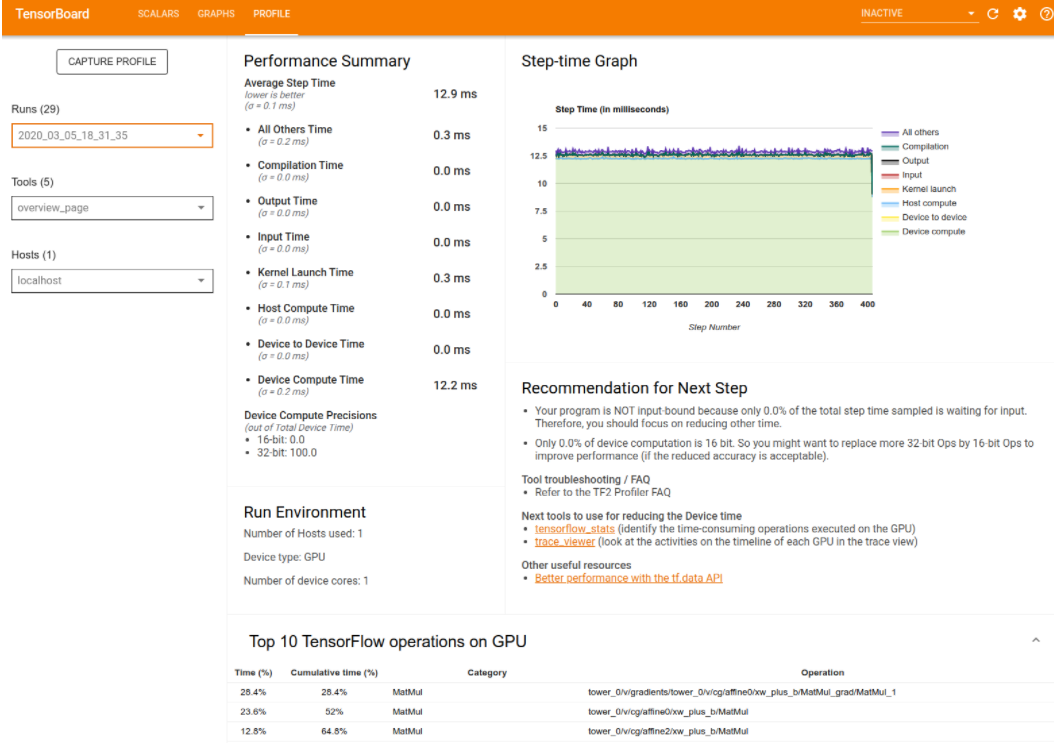

`Performance Summary`: Displays a high-level summary of your model performance. The performance summary has two parts:

1) Step-time breakdown: Breaks down the average step time into multiple categories of where time is spent:
  - Compilation: Time spent compiling kernels.
  - Input: Time spent reading input data.
  - Output: Time spent reading output data.
  - Kernel launch: Time spent by the host to launch kernels
  - Host compute time..
  - Device-to-device communication time.
  - On-device compute time.
  - All others, including Python overhead.
2) Device compute precisions - Reports the percentage of device compute time that uses 16 and 32-bit computations.

`Step-time Graph:` Displays a graph of device step time (in milliseconds) over all the steps sampled. Each step is broken into the multiple categories (with different colors) of `where time is spent`. The red area corresponds to the portion of the step time the devices were sitting idle waiting for input data from the host. The green area shows how much of time the device was actually working.

`Recommendation for Next Step`: Reports when a model is input bound and recommends tools you can use to locate and resolve model performance bottlenecks.

2) `Input pipeline analyzer`: When a TensorFlow program reads data from a file it begins at the top of the TensorFlow graph in a pipelined manner. The read process is divided into multiple data processing stages connected in series, where the output of one stage is the input to the next one. This system of reading data is called the input pipeline.

A typical pipeline for reading records from files has the following stages:

- File reading.
- File preprocessing (optional).
- File transfer from the host to the device.

An inefficient input pipeline can severely slow down your application. An application is considered `input bound` when it spends a significant portion of time in the input pipeline. Use the insights obtained from the input pipeline analyzer to understand where the input pipeline is inefficient.

To open the input pipeline analyzer, select `Profile`, then select `input_pipeline_analyzer` from the `Tools` dropdown.
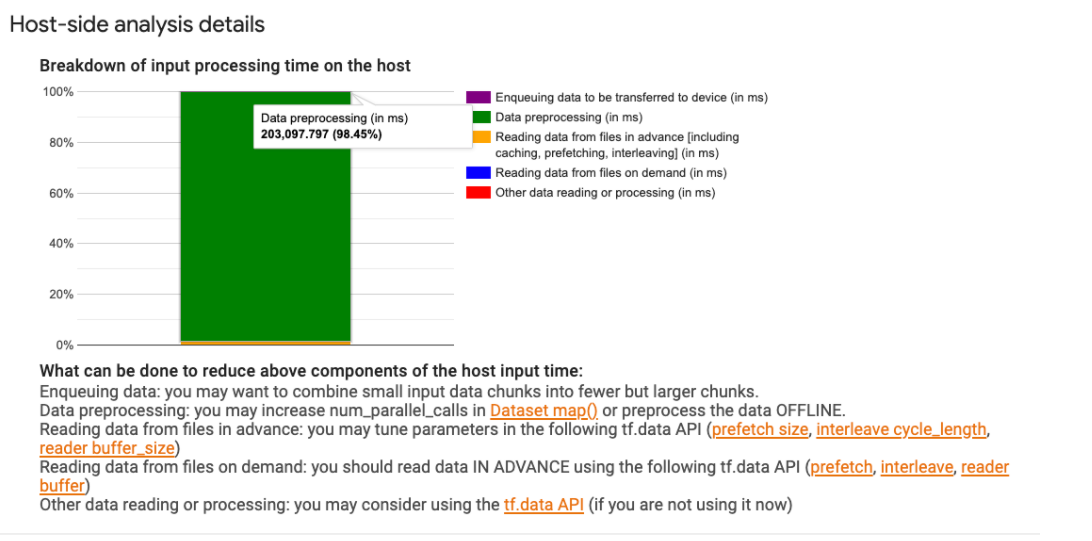
The `input pipeline analyzer`dashboard contains three sections:

- `Summary`: Summarizes the overall input pipeline with information on whether your application is input bound and, if so, by how much.
- `Device-side analysis:` Displays detailed, device-side analysis results, including the device step-time and the range of device time spent waiting for input data across cores at each step.
- `Host-side analysis:` Shows a detailed analysis on the host side, including a breakdown of input processing time on the host.

3) The `TensorFlow Stats` tool displays the performance of every TensorFlow op (op) that is executed on the host or device during a profiling session.

4) `Trace viewer interface:`When you open the trace viewer, it appears displaying your most recent run
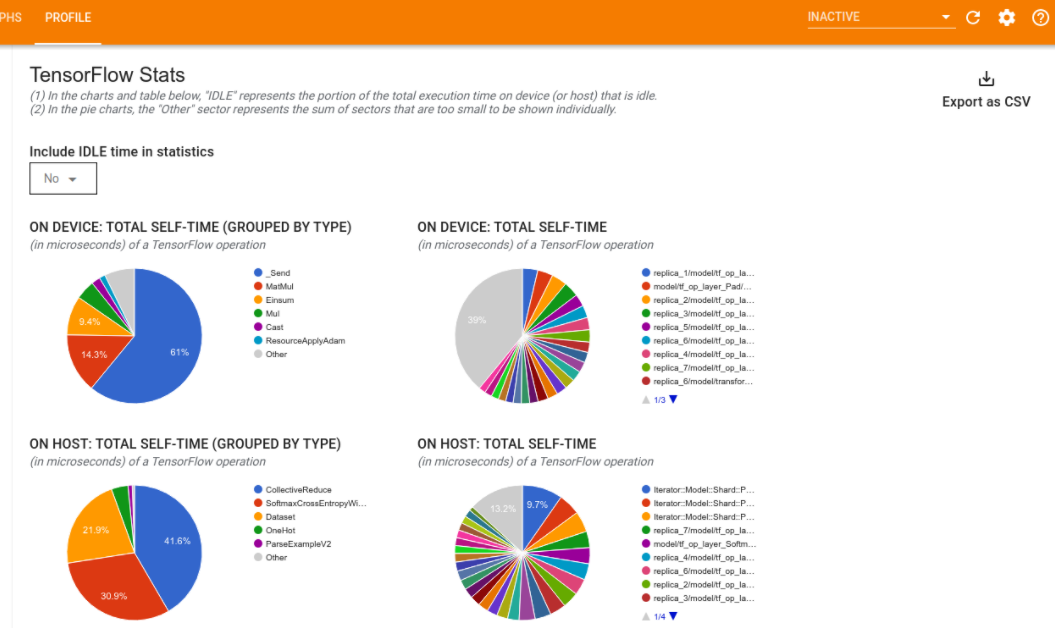
This view contains the following main elements:

- `Timeline pane:` Shows ops that the device and the host executed over time.
- `Details pane:` Shows additional information for ops selected in the Timeline pane.

The Timeline pane contains the following elements:

   - `Top bar:` Contains various auxiliary controls.
   - `Time axis:` Shows time relative to the beginning of the trace.
   - `Section and track labels:` Each section contains multiple tracks and has a triangle on the left that you can click to expand and collapse the section. There is one section for every processing element in the system.
   - `Tool selector:` Contains various tools for interacting with the trace viewer such as Zoom, Pan, Select, and Timing. Use the Timing tool to mark a time interval.
- `Events:` These show the time during which an op was executed or the duration of meta-events, such as training steps.

5) `GPU kernel stats`: This tool shows performance statistics and the originating op for every GPU accelerated kernel.

6) The `Memory Profile` tool monitors the memory usage of your device during the profiling interval. You can use this tool to:

    - Debug out of memory (OOM) issues by pinpointing peak memory usage and the corresponding memory allocation to TensorFlow ops. You can also debug       OOM issues that may arise when you run multi-tenancy inference.
    - Debug memory fragmentation issues.
    
7) The `Pod Viewer` tool shows the breakdown of a training step across all workers.

In [8]:
!kill 8182 
""" When you are running the model multiple times and see that previous tensorboard was relaunching again,
try to kill that previous version using `!kill` followed by the number it is showing """

/bin/bash: line 0: kill: (8182) - No such process


' When you are running the model multiple times and see that previous tensorboard was relaunching again,\ntry to kill that previous version using `!kill` followed by the number it is showing '

In [1]:
%tensorboard --logdir=logs_1

UsageError: Line magic function `%tensorboard` not found.


The Profile tab opens the Overview page which shows you a high-level summary of your model performance. Looking at the Step-time Graph on the right, you can see that the model is `highly input bound` (i.e., it spends a lot of time in the data input piepline). The Overview page also gives you recommendations on potential next steps you can follow to optimize your model performance.

# 7 - Implementing few recommendations given by the profiler:
- As we can see, our program is HIGHLY input-bound because 63.4% of the total step time sampled is waiting for input. Therefore, you should first focus on reducing the input time.

- we can use the `tf.data` API to optimize the input pipeline. In this case, let's `cache` the training dataset and `prefetch` the data to ensure that there is always data available for the GPU to process

- again loading the data

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

### Adding `cache` and `prefetch` functions to both `train` and `test` pipeline

- `cache:` The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

- `prefetch:` Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

    - The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step

    - You could either manually tune this value, or set it to tf.data.`AUTOTUNE`, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [11]:
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.batch(128)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

- Building the same model to compare the variatio

In [13]:
tf.keras.backend.clear_session()
"""If you are creating many models in a loop, this global state will consume an increasing amount of memory
over time, and you may want to clear it. Calling clear_session() releases the global state:
this helps avoid clutter from old models and layers, especially when memory is limited."""

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

- Storing the new logs inside `logs_2` folder

In [15]:
logs = "logs_2/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '100,120')

model.fit(ds_train,
          epochs=2,
          validation_data=ds_test,
          callbacks = [tboard_callback])

## Ignore the cleanup called warning IF shown

Epoch 1/2
 72/469 [===>..........................] - ETA: 0s - loss: 0.3844 - accuracy: 0.8679

2022-02-18 17:27:49.975224: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-02-18 17:27:49.975273: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-02-18 17:27:49.975634: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


170/469 [=========>....................] - ETA: 0s - loss: 0.3750 - accuracy: 0.8687

2022-02-18 17:27:50.239439: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-02-18 17:27:50.239490: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-02-18 17:27:50.294140: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-02-18 17:27:50.298002: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-02-18 17:27:50.308269: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs_2/20220218-172749/plugins/profile/2022_02_18_17_27_50

2022-02-18 17:27:50.315197: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs_2/20220218-172749/plugins/profile/2022_02_18_17_27_50/test-vm-3.trace.json.gz
2022-02-18 17:27:50.318928: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs_2/20220218-172749/plugins/profile/2022_02_18_17_27_

469/469 [==============================] - 1s 3ms/step - loss: 0.3653 - accuracy: 0.8707 - val_loss: 0.3909 - val_accuracy: 0.8628
Epoch 2/2
469/469 [==============================] - 1s 3ms/step - loss: 0.3387 - accuracy: 0.8790 - val_loss: 0.3780 - val_accuracy: 0.8668


In [17]:
!kill 8669 
""" When you are running the model multiple times and see that previous tensorboard was relaunching again,
try to kill that previous version using `!kill` followed by the number it is showing """

/bin/bash: line 0: kill: (8669) - No such process


' When you are running the model multiple times and see that previous tensorboard was relaunching again,\ntry to kill that previous version using `!kill` followed by the number it is showing '

# 8 - Relaunching the `tensorboard` again to see the new `profiler`

In [18]:
%tensorboard --logdir=logs_2

- Now, we can see the time taken by the input pipeline has been reduced after adding `cache` and `prefetching` the data pipeline as recommended by `tf profiler`

`NOTE`: `tfprofiler` works best when used with a single GPU, a multi-GPU Setup, or a TPU setup. The reason is while the GPU's/TPU are doing the complex convolution operations (forward and backward pass) the CPU is collecting data for the next batch. If the GPU/TPU device is not attached, then the CPU would be doing the convolution operation as well as the preprocess operations and there is little to no scope for parallelization.